Давайте посмотрим, как работает алгоритм случайного леса, на примере. 

Пусть у нас есть набор данных со следующими факторами:

 — возраст,
 — доход в тысячах рублей,
 — группа крови.
Целевой признак () — подвергался ли человек операции хотя бы раз в жизни (1 — да, 0 — нет).

Тогда, если мы обучим алгоритм случайного леса на представленных данных, мы получим следующую картину:

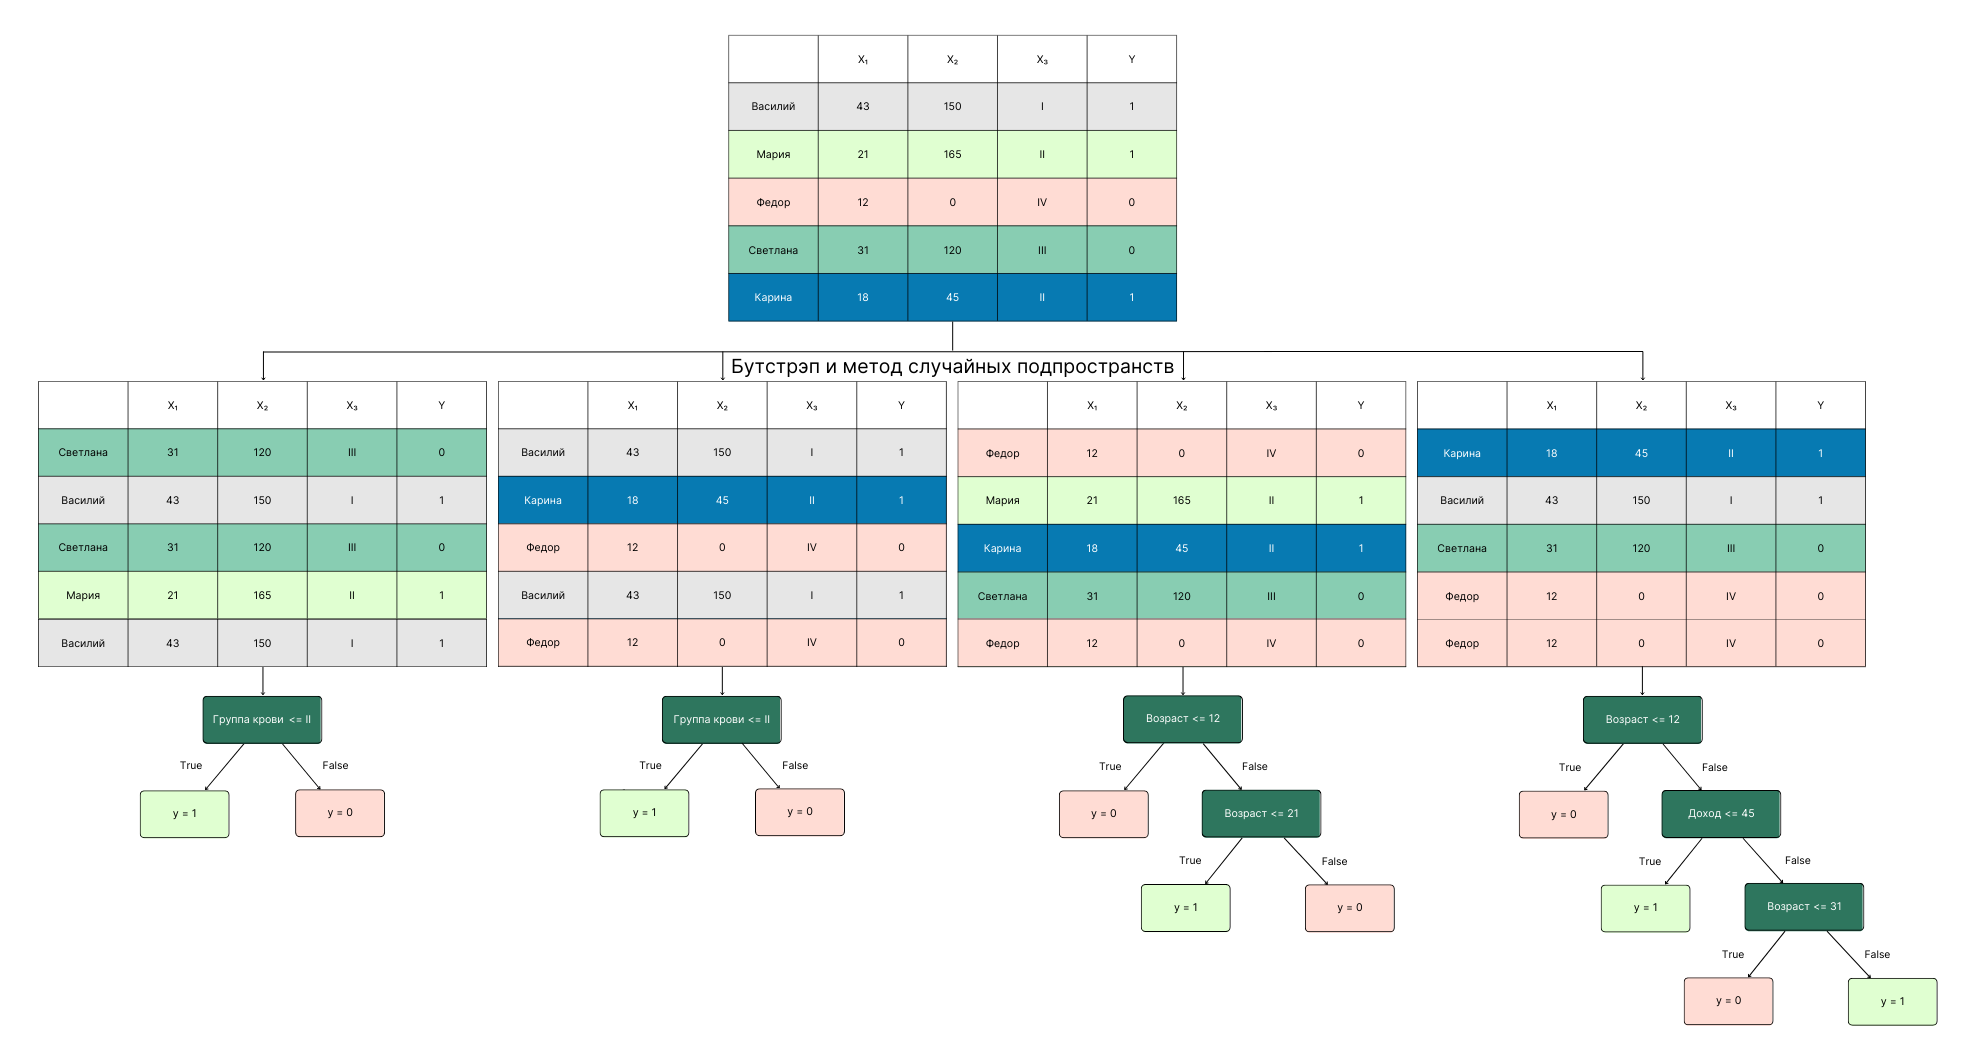

Количество объектов в наборе данных N=5, а количество факторов — M=3 (+1 целевой признак, его мы не включаем в размерность). Таким образом, размер таблицы наблюдений — (5, 3). Количество деревьев в лесу K=4.

На первом этапе алгоритма мы формируем K=4 бутстрэп выборки размером (5, 3), выбирая из таблицы строки случайным образом с возможностью повторения.
На втором этапе мы случайным образом выбираем L=2 признаков из каждой таблицы и получаем четыре выборки размером (5, 2).
На третьем этапе мы обучаем K=4 деревьев решений, каждое на своей выборке.
Обратите внимание, что деревья, из которых состоит лес, могут быть различной глубины и структуры в зависимости от того, насколько просто была разделима поданная выборка.

Теперь, когда поступят новые данные, нам останется только подать их на вход каждого из деревьев, получить предсказания, а затем усреднить их путём мажоритарного голосования и получить ответ:



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

import plotly 
import plotly.express as px
import warnings 

warnings.filterwarnings("ignore")
from sklearn import linear_model #линейные модели
from sklearn import ensemble
    

In [2]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


In [3]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Основные параметры RandomForestClassifier

- n_estimators — количество деревьев в лесу (число K из бэггинга; по умолчанию равно 100);
- criterion — критерий информативности разбиения для каждого из деревьев ('gini' — критерий Джини и 'entropy' — энтропия Шеннона; по умолчанию — 'gini');
- max_depth — максимальная глубина одного дерева (по умолчанию — None, то есть глубина дерева не ограничена);
- max_features — максимальное число признаков, которые будут использоваться каждым из деревьев (число L из метода случайных подпространств; по умолчанию — 'sqrt'; для обучения каждого из деревьев используется  признаков, где  — число признаков в начальном наборе данных);
- min_samples_leaf — минимальное число объектов в листе (по умолчанию — 1);
- random_state — параметр, отвечающий за генерацию случайных чисел.

Давайте создадим лес из 500 деревьев решений с максимальной глубиной 3. В качестве критерия информативности будем использовать энтропию. Число признаков в каждом дереве будем вычислять как .

Затем обучим модель случайного леса с помощью метода fit(), сделаем предсказание классов с помощью метода predict() и рассчитаем метрики.

In [4]:
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=3, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X, y)
 
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       493
           1       0.73      0.57      0.64       264

    accuracy                           0.78       757
   macro avg       0.76      0.73      0.74       757
weighted avg       0.77      0.78      0.77       757



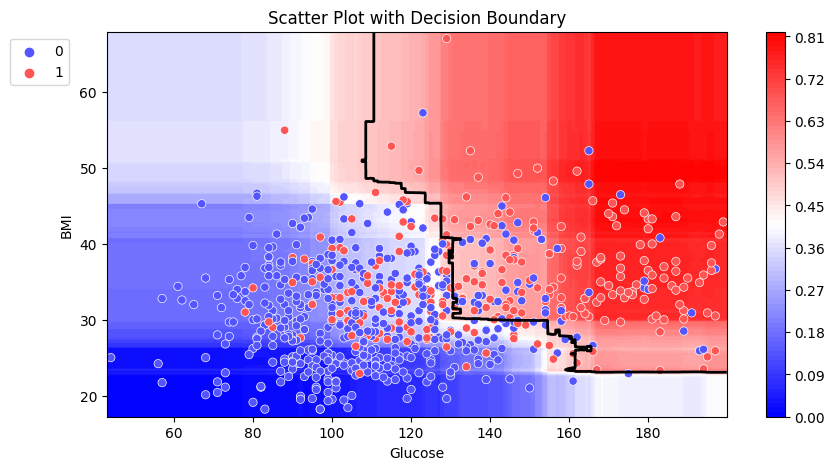

In [5]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость (линию, где вероятность равна 0.5)
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
plot_probabilities_2d(X, y, rf_clf_2d)

In [6]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']
 
 
#Создаём объект класса RandomForestClassifier
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=300, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X, y)
 
#Делаем предсказание класса
y_pred = rf_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       493
           1       0.85      0.77      0.80       264

    accuracy                           0.87       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.87      0.87      0.87       757



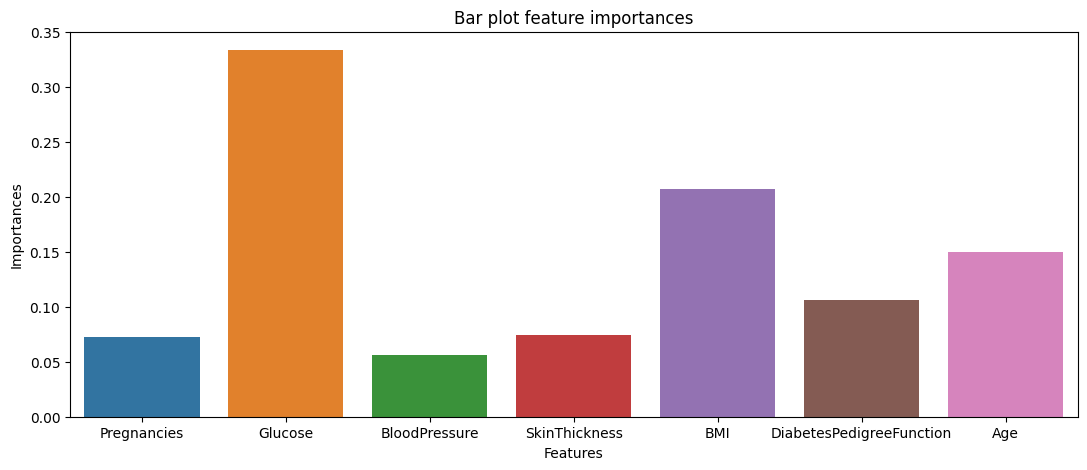

In [7]:
rf_clf_full.predict_proba(X)
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [11]:
wine_data = pd.read_csv('data/winequality-red.csv', sep=';')
wine_data['quality'] = wine_data['quality'].apply(lambda x: 1 if x>=6 else 0)
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']
#Затем разделим выборку на тренировочную и тестовую:

from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:

 
 
#Создаём объект класса RandomForestClassifier
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10,
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X_train, y_train)
 
#Делаем предсказание класса
y_pred = rf_clf_full.predict(X_test)
y_predt = rf_clf_full.predict(X_train)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))
print(metrics.classification_report(y_train, y_predt))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       141
           1       0.79      0.75      0.77       179

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       603
           1       0.87      0.84      0.85       676

    accuracy                           0.85      1279
   macro avg       0.85      0.85      0.85      1279
weighted avg       0.85      0.85      0.85      1279

